# Investigate SportVU/Play-by-Play Data
This is the notebook that found the duplicated event data and the overlapping moments.
It inspired the creation of the SportVUCleaner class

## Import relevant packages

In [7]:
import numpy as np
import pandas as pd
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
from datasets import load_dataset
from sportypy.surfaces.basketball import NBACourt
from nba_api.stats.endpoints import commonallplayers, playergamelog

import warnings
warnings.filterwarnings("ignore")

## Load combined play-by-play and sportvu tracking data from huggingface
Details on the structure of the dataset can be found [here](https://huggingface.co/datasets/dcayton/nba_tracking_data_15_16)

In [6]:
# Path to the dataset script
script_path = '../scripts/nba_tracking_data_loader.py'

test_name = "12.30.2015.LAL.at.BOS.7z"

# Load the dataset
dataset = load_dataset(script_path, name=test_name, keep_in_memory=False, trust_remote_code=True)
hf_data = dataset['train']

Generating train split: 0 examples [00:00, ? examples/s]

## Locate moments assigned to multiple events and determine de-duping rule

Details about what each event number is is listed below:

From the descriptions of the event types, it looks like these events map to the same moments because they are all in the same possession. I'm only interested in possessions that had a shot in it.

In [8]:
after_set = set()
continuous_event = []
for i in range(len(hf_data)-1):
    current_type = hf_data[i]['event_info']['type']
    if len(continuous_event) == 0:
        continuous_event.append(current_type)
    try:
        start_timestamp1 = hf_data[i]['moments'][0]['timestamp']
        end_timestamp1 = hf_data[i]['moments'][-1]['timestamp']
        start_timestamp2 = hf_data[i+1]['moments'][0]['timestamp']
        end_timestamp2 = hf_data[i+1]['moments'][-1]['timestamp']
    except:
        continue
    next_contained_in_current = start_timestamp2 >= start_timestamp1 and end_timestamp2 <= end_timestamp1 
    current_contained_in_next = start_timestamp1 >= start_timestamp2 and end_timestamp1 <= end_timestamp2
    
    # If the timestamps of the two events are the same, consider it a continguous string of events
    if (start_timestamp1 == start_timestamp2) and (end_timestamp1 == end_timestamp2):
        next_type = hf_data[i+1]['event_info']['type']
        continuous_event.append(next_type)
    else:
        if len(continuous_event) > 1:
            after_set.add(tuple(continuous_event))
        continuous_event = []
after_set

{(1, 6),
 (1, 6, 8),
 (1, 6, 9),
 (1, 9),
 (1, 9, 8),
 (1, 13),
 (2, 1, 4),
 (2, 2, 4, 4),
 (2, 4),
 (2, 4, 1),
 (2, 4, 1, 6),
 (2, 4, 2, 4),
 (2, 4, 2, 4, 1),
 (2, 4, 2, 4, 5),
 (2, 4, 2, 4, 9),
 (2, 4, 6),
 (2, 4, 6, 8, 8),
 (2, 4, 8),
 (2, 13, 4),
 (3, 3),
 (3, 3, 4),
 (3, 3, 9),
 (3, 4),
 (3, 4, 3, 4),
 (3, 4, 8, 3),
 (3, 4, 8, 3, 9),
 (3, 8, 3),
 (3, 8, 3, 4),
 (3, 8, 3, 9),
 (3, 8, 8, 8, 3),
 (3, 8, 8, 8, 8),
 (5, 1),
 (5, 6),
 (5, 6, 18),
 (5, 8),
 (5, 8, 8, 8),
 (5, 13),
 (6, 5),
 (6, 8, 8),
 (6, 9),
 (8, 8),
 (8, 8, 3),
 (8, 8, 3, 4),
 (8, 8, 8),
 (9, 8)}

## Remove moments assigned to multiple events

In [9]:
cleaned_data = []

continuous_events = {
    'indices': [],
    'event_type': []
}
for i in range(len(hf_data)-1):
    current_type = hf_data[i]['event_info']['type']
    
    # If the continuous events list is empty, add the current event to it
    if len(continuous_events['indices']) == 0:
        continuous_events['indices'].append(i)
        continuous_events['event_type'].append(current_type)
    try:
        #Get start and end of the current and next event
        start_timestamp1 = hf_data[i]['moments'][0]['timestamp']
        end_timestamp1 = hf_data[i]['moments'][-1]['timestamp']
        start_timestamp2 = hf_data[i+1]['moments'][0]['timestamp']
        end_timestamp2 = hf_data[i+1]['moments'][-1]['timestamp']
    except:
        continue
    
    # If next event and current event are duplicates, add the next event to the continuous events list
    if (start_timestamp1 == start_timestamp2) and (end_timestamp1 == end_timestamp2):
        next_type = hf_data[i+1]['event_info']['type']
        continuous_events['indices'].append(i+1)
        continuous_events['event_type'].append(next_type)
    
    # If the next event is not a duplicate
    else:
        if len(continuous_events['indices']) > 1:
            
            # If the continuous event includes a made shot, use it as the event data for posession purposes
            if 1 in continuous_events['event_type']:
                proper_index = continuous_events['indices'][continuous_events['event_type'].index(1)]
                cleaned_data.append(hf_data[proper_index])
            
            # If the continuous eevnt does not include a made shot but includes a missed shot, use it as the event data for posession purposes
            elif 2 in continuous_events['event_type']:
                proper_index = continuous_events['indices'][continuous_events['event_type'].index(2)]
                cleaned_data.append(hf_data[proper_index])
        
        # If there is only one event in the continuous events list
        else:
            # If the event is a shot, add it to the cleaned data
            if hf_data[i]['event_info']['type'] in [1, 2]:
                cleaned_data.append(hf_data[i])
        
        # Reset the continuous events list
        continuous_events = {
            'indices': [],
            'event_type': []
        }
print(len(hf_data))
print(len(cleaned_data))

482
163


## Investigate overlap

It seems that there is overlap between consecutive events even after deduplication

In [10]:
total_moments = 0
for i in range(len(cleaned_data)-1):

    start_timestamp1 = cleaned_data[i]['moments'][0]['timestamp']
    end_timestamp1 = cleaned_data[i]['moments'][-1]['timestamp']
    start_timestamp2 = cleaned_data[i+1]['moments'][0]['timestamp']
    end_timestamp2 = cleaned_data[i+1]['moments'][-1]['timestamp']
    duration1 = end_timestamp1 - start_timestamp1
    duration2 = end_timestamp2 - start_timestamp2

    if start_timestamp2 <= end_timestamp1:
        overlap = end_timestamp1 - start_timestamp2
        if overlap >= duration1:
            print(f"{i}: Current contained in the next")
        elif overlap >= duration2:
            print(f"{i}: Next contained in the current")
        else:
            overlap_fraction = overlap / (duration1 + duration2)
            print(f"{i}: {round(100*overlap_fraction, 0)}%")
        total_moments += 1
print(total_moments)

4: 14.0%
7: 14.0%
9: 19.0%
10: 14.0%
12: 19.0%
14: 12.0%
15: 16.0%
16: Next contained in the current
18: 17.0%
19: 18.0%
20: 24.0%
26: 17.0%
28: 26.0%
31: 18.0%
34: 18.0%
35: 18.0%
36: 19.0%
40: 11.0%
41: Next contained in the current
43: 14.0%
46: 21.0%
48: 20.0%
50: 15.0%
51: 18.0%
52: 18.0%
53: 21.0%
55: 11.0%
56: 12.0%
57: 13.0%
58: 14.0%
59: 12.0%
60: 5.0%
61: 5.0%
62: 13.0%
63: 23.0%
64: 13.0%
65: 16.0%
67: 18.0%
69: 10.0%
71: 15.0%
73: 15.0%
74: 17.0%
76: 27.0%
77: 19.0%
79: 19.0%
80: 20.0%
82: 10.0%
84: 18.0%
88: 12.0%
89: 13.0%
93: 14.0%
94: 15.0%
96: 18.0%
97: 21.0%
98: 17.0%
99: 16.0%
100: 9.0%
102: 11.0%
103: 15.0%
105: Next contained in the current
107: 11.0%
108: 11.0%
112: 34.0%
116: 7.0%
119: 12.0%
120: 15.0%
121: 18.0%
122: 13.0%
123: 7.0%
124: 15.0%
128: 16.0%
129: 15.0%
130: 16.0%
132: 1.0%
133: 6.0%
134: 22.0%
135: 12.0%
136: 15.0%
137: Current contained in the next
138: 26.0%
142: 13.0%
143: 16.0%
145: 3.0%
146: 10.0%
147: 23.0%
149: 12.0%
150: 9.0%
153: 14.0%
156:

## Remove overlap
Removing overlap by finding:
* Which side the offensive team is shooting on
* Removing any frames where the halfcourt offense is not in motion, defined as not all 5 offensive players being in the halfcourt

In [11]:
rim_locations = {
    'left': {
        'x': 5.25,
        'y': 25,
        'z': 10
    },
    'right': {
        'x': 88.75,
        'y': 25,
        'z': 10
    }
}

shot_attempt_radius = 3

def euclidean_distance_2d(point1, point2):
    """Calculate the Euclidean distance between two points in 3D space."""
    return np.sqrt((point1['x'] - point2['x'])**2 + (point1['y'] - point2['y'])**2)

def euclidean_distance_3d(point1, point2):
    """Calculate the Euclidean distance between two points in 3D space."""
    return np.sqrt((point1['x'] - point2['x'])**2 + (point1['y'] - point2['y'])**2 + (point1['z'] - point2['z'])**2)

def determine_offensive_side(row, radius):
    """
    Determine which side of the court contained more frames with the basketball coordinates
    within a certain radius of the rim location.
    
    Parameters:
    - ball_positions: List of dictionaries with keys 'x', 'y', 'z' representing the ball's coordinates in each frame.
    - radius: The radius within which to check the ball's proximity to the rim.
    
    Returns:
    - 'left' or 'right' indicating which side had more frames within the radius.
    """
    left_count = 0
    right_count = 0

    moments = row['moments']
    ball_positions = [{'x': moment['ball_coordinates']['x'], 'y': moment['ball_coordinates']['y'], 'z': moment['ball_coordinates']['z']} for moment in moments]
    
    # Calculate distance of the ball to the left and right rim over the entire moment. Pick which ever side has more frames where the ball is closer to that rim
    for ball_pos in ball_positions:
        left_distance = euclidean_distance_3d(ball_pos, rim_locations['left'])
        right_distance = euclidean_distance_3d(ball_pos, rim_locations['right'])
        
        if left_distance <= radius:
            left_count += 1
        if right_distance <= radius:
            right_count += 1
    if left_count > right_count:
        return 'left'
    else:
        return 'right'

def assign_offensive_side(data):
    """
    Assign the offensive side to each row in the dataset.
    
    Parameters:
    - data: List of dictionaries representing each row in the dataset.
    
    Returns:
    - List of dictionaries with an additional key 'offensive_side' indicating which side had more frames within the radius.
    """
    
    # Split the data into quarters
    data_quarters = {
        i: [row for row in data if row['moments'][0]['quarter'] == i]
        for i in range(1, 5)
    }

    # Extract the home and away team ids
    home_team_id = data[0]['home']['teamid']
    away_team_id = data[0]['visitor']['teamid']
    cleaned_data_sides = []
    for quarter, rows in data_quarters.items():
        side_counts = {
            home_team_id: [],
            away_team_id: []
        }
        # Determine the offensive side for each event in the quarter
        for row in rows:
            possession_team_id = row['event_info']['possession_team_id']
            side = determine_offensive_side(row, shot_attempt_radius)
            side_counts[possession_team_id].append(side)
        
        # Count the number of times each team was on the left and right side
        home_team_counts = Counter(side_counts[home_team_id])
        # away_team_counts = Counter(side_counts[away_team_id])

        # Assign the side for which most possessions occured on for each team
        if home_team_counts['left'] > home_team_counts['right']:
            home_team_side = 'left'
            away_team_side = 'right'
        else:
            home_team_side = 'right'
            away_team_side = 'left'

        # if away_team_counts['left'] > away_team_counts['right']:
        #     away_team_side = 'left'
        # else:
        #     away_team_side = 'right'

        # Add the correct court side to the event data
        for row in rows:
            possession_team_id = row['event_info']['possession_team_id']
            if possession_team_id == home_team_id:
                row['event_info']['offensive_side'] = home_team_side
            else:
                row['event_info']['offensive_side'] = away_team_side
            cleaned_data_sides.append(row)
    
    return cleaned_data_sides

def get_offensive_frames(row):
    """
    Get the frames where the basketball was within a certain radius of the rim location.
    
    Parameters:
    - ball_positions: List of dictionaries with keys 'x', 'y', 'z' representing the ball's coordinates in each frame.
    
    Returns:
    - List of dictionaries with keys 'x', 'y', 'z' representing the ball's coordinates in each frame where it was within the radius.
    """
    new_row = deepcopy(row)
    offensive_frames = []
    offensive_side = row['event_info']['offensive_side']
    offensive_team_id =  row['event_info']['possession_team_id']
    moments = row['moments']
    for moment in moments:
        player_xs = [player['x'] for player in moment['player_coordinates'] if player['teamid'] == offensive_team_id]
        
        # Check to see if all players are on the correct side of the court
        if offensive_side == 'left':
            if all([x <= 47 for x in player_xs]):
                offensive_frames.append(moment)
        else:
            if all([x >= 47 for x in player_xs]):
                offensive_frames.append(moment)
    
    new_row['moments'] = offensive_frames
    return new_row

cleaned_data_sides = assign_offensive_side(cleaned_data)

cleaned_transition_data = []
for i, row in enumerate(cleaned_data_sides):
    offensive_frames = get_offensive_frames(row)
    if len(offensive_frames['moments']) > 0:
        cleaned_transition_data.append(offensive_frames)

total_moments = 0
for i in range(len(cleaned_transition_data)-1):

    try:
        start_timestamp1 = cleaned_transition_data[i]['moments'][0]['timestamp']
        end_timestamp1 = cleaned_transition_data[i]['moments'][-1]['timestamp']
        start_timestamp2 = cleaned_transition_data[i+1]['moments'][0]['timestamp']
        end_timestamp2 = cleaned_transition_data[i+1]['moments'][-1]['timestamp']
        duration1 = end_timestamp1 - start_timestamp1
        duration2 = end_timestamp2 - start_timestamp2
    except:
        continue

    if start_timestamp2 <= end_timestamp1:
        overlap = end_timestamp1 - start_timestamp2
        if overlap >= duration1:
            print(f"{i}: Current contained in the next")
        elif overlap >= duration2:
            print(f"{i}: Next contained in the current")
        else:
            overlap_fraction = overlap / (duration1 + duration2)
            print(f"{i}: {round(100*overlap_fraction, 0)}%")
        total_moments += 1
print(total_moments)

59: 16.0%
67: 3.0%
130: Current contained in the next
3


# See what happened on the play
The sections below write in text what happened during the event and plot the ball location. This allows us to investigate duplication and overlap issues and how well the solution is addressing those issues

## Print out a description of what happened during an event as well as the previous event and the event after

In [12]:
test_idx = 25
dataset = cleaned_transition_data
print("---"*5 + f"[Event ID: {test_idx-1}]" + "---"*5)

try:
    print(dataset[test_idx-1]['event_info']['desc_home'])
    print(dataset[test_idx-1]['event_info']['desc_away'])
    print(f"Quarter: {dataset[test_idx-1]['moments'][0]['quarter']} - Time: {int(dataset[test_idx-1]['moments'][0]['game_clock']/60)}:{int(dataset[test_idx-1]['moments'][0]['game_clock']%60)}")
    print(f"Quarter: {dataset[test_idx-1]['moments'][-1]['quarter']} - Time: {int(dataset[test_idx-1]['moments'][-1]['game_clock']/60)}:{int(dataset[test_idx-1]['moments'][-1]['game_clock']%60)}\n")
except:
    print("Error processing event")

print("---"*5 + f"[Event ID: {test_idx}]" + "---"*5)
try:
    print(dataset[test_idx]['event_info']['desc_home'])
    print(dataset[test_idx]['event_info']['desc_away'])
    print(f"Quarter: {dataset[test_idx]['moments'][0]['quarter']} - Time: {int(dataset[test_idx]['moments'][0]['game_clock']/60)}:{int(dataset[test_idx]['moments'][0]['game_clock']%60)}")
    print(f"Quarter: {dataset[test_idx]['moments'][-1]['quarter']} - Time: {int(dataset[test_idx]['moments'][-1]['game_clock']/60)}:{int(dataset[test_idx]['moments'][-1]['game_clock']%60)}\n")
except:
    print("Error processing event")


print("---"*5 + f"[Event ID: {test_idx+1}]" + "---"*5)
try:
    print(dataset[test_idx+1]['event_info']['desc_home'])
    print(dataset[test_idx+1]['event_info']['desc_away'])
    print(f"Quarter: {dataset[test_idx+1]['moments'][0]['quarter']} - Time: {int(dataset[test_idx+1]['moments'][0]['game_clock']/60)}:{int(dataset[test_idx+1]['moments'][0]['game_clock']%60)}")
    print(f"Quarter: {dataset[test_idx+1]['moments'][-1]['quarter']} - Time: {int(dataset[test_idx+1]['moments'][-1]['game_clock']/60)}:{int(dataset[test_idx+1]['moments'][-1]['game_clock']%60)}")
except:
    print("Error processing event")


---------------[Event ID: 24]---------------
nan
Randle 6' Turnaround Hook Shot (2 PTS)
Quarter: 1 - Time: 4:16
Quarter: 1 - Time: 4:5

---------------[Event ID: 25]---------------
nan
MISS Russell 11' Floating Jump Shot
Quarter: 1 - Time: 3:49
Quarter: 1 - Time: 3:40

---------------[Event ID: 26]---------------
Crowder 25' 3PT Jump Shot (12 PTS) (Thomas 3 AST)
nan
Quarter: 1 - Time: 3:35
Quarter: 1 - Time: 3:30


## Plot ball location of the play

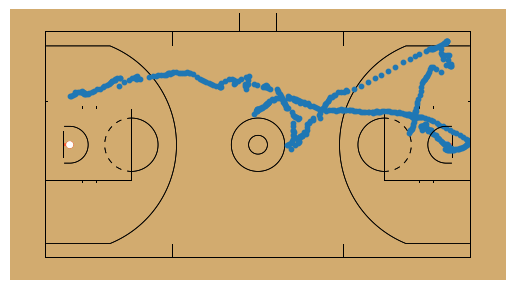

In [13]:
idx1 = 25
dataset = cleaned_data

moments = dataset[idx1]['moments']
x_positions = [moment['ball_coordinates']['x'] for moment in moments]
y_positions = [50 - moment['ball_coordinates']['y'] for moment in moments]

# Convert lists to numpy arrays for easier handling
x_positions = np.array(x_positions)
y_positions = np.array(y_positions)

court = NBACourt(x_trans=47, y_trans=25)
fig, ax = plt.subplots(1, 1)
court.draw(ax = ax)
court.scatter(
    x_positions,
    y_positions,
    s=10
)

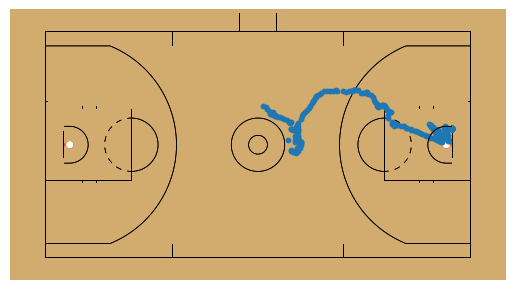

In [14]:
idx2 = 25
dataset = cleaned_transition_data

moments = dataset[idx2]['moments']
x_positions = [moment['ball_coordinates']['x'] for moment in moments]
y_positions = [50 - moment['ball_coordinates']['y'] for moment in moments]

# Convert lists to numpy arrays for easier handling
x_positions = np.array(x_positions)
y_positions = np.array(y_positions)

court = NBACourt(x_trans=47, y_trans=25)
fig, ax = plt.subplots(1, 1)
court.draw(ax = ax)
court.scatter(
    x_positions,
    y_positions,
    s=10
)